In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import matplotlib as mpl

#sns.set_palette('colorblind')
sns.set_style('whitegrid')
sns.set_palette("colorblind")

mpl.rcParams["axes.titlesize"] = 12.
mpl.rcParams["axes.labelsize"] = 12.
mpl.rcParams["axes.titleweight"] = "bold"
mpl.rcParams["axes.labelweight"] = "bold"
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = "serif"
mpl.rcParams['font.weight'] = "bold"

ALGOS = [ 
    "C-TRPO",
]

ENVS = (
    "SafetyAntVelocity-v1", 
)


def get_df(
    experiments,
    algo_subset=None, 
    env_subset=None
):
    df = pd.DataFrame()
    for exp in experiments:
        bm_folder = os.path.join("../data/runs/noise", exp)
        if not os.path.exists(bm_folder):
            continue
        envs = env_subset or [f for f in os.listdir(bm_folder) if not f.startswith('.') and not f.endswith('.pdf')]
        for env in envs:
            env_folder = os.path.join(bm_folder, env)
            if not os.path.exists(env_folder):
                    continue
            algos = algo_subset or [f for f in os.listdir(env_folder) if not f.startswith('.') and not f.endswith('.pdf')]
            for algo in algos:
                algo_folder = os.path.join(env_folder, algo)
                if not os.path.exists(algo_folder):
                    continue
                for seed in [f for f in os.listdir(algo_folder) if not f.startswith('.') and not f.endswith('.pdf')]:
                    progress_csv = os.path.join(algo_folder, seed, "progress.csv")
                    try:
                        new_df = pd.read_csv(progress_csv)
                        # print(progress_csv)
                        new_df["seed"] = seed
                        new_df["algo"] = algo + f" ({exp})"
                        new_df["env"] = env
                        new_df["exp"] = exp
                        new_df = new_df.sort_values(by=['Train/TotalSteps'], ascending=True)
                        new_df["Metrics/EpCumCostViolation"] = (new_df["Metrics/EpCost"] - 25.0).clip(lower=0)
                        new_df["Metrics/EpCumCostViolation"] = new_df["Metrics/EpCumCostViolation"].cumsum()
                        df = pd.concat([df, new_df], ignore_index=True)
                    except (pd.errors.EmptyDataError, pd.errors.ParserError):
                        continue
    #df = df.sort_values(by=['algo'], ascending=True)
    
    return df

In [24]:
def plot_env(df, env, xmax=10e6, diagnostics=True, cost_ci=True, 
             alpha=1., start_others_at=2, plot_cost_limit=True, label_map=None):
    
    df = df[(df["env"] == env)].sort_values(by=["algo", "Train/TotalSteps", "seed"], ascending=True)
    
    _, axs = plt.subplots(1, 3, figsize=(10, 3), layout = 'tight')
    
    algos = list(df["algo"].drop_duplicates())
    for i, algo in enumerate(algos):
        seeds = list(df[(df["algo"] == algo)]["seed"].drop_duplicates())
        for j, seed in enumerate(seeds):
            data = {
                "steps": df[(df["algo"] == algo)][(df["seed"] == seed)]["Train/TotalSteps"].to_numpy(),
                "reward": df[(df["algo"] == algo)][(df["seed"] == seed)]["Metrics/EpRet"].to_numpy(),
                "cost": df[(df["algo"] == algo)][(df["seed"] == seed)]["Metrics/EpCost"].to_numpy(),
                "violation": df[(df["algo"] == algo)][(df["seed"] == seed)]["Metrics/EpCumCostViolation"].to_numpy(),
                "algo": df[(df["algo"] == algo)][(df["seed"] == seed)]["algo"].to_numpy()
            }

            axs[0].plot(data["steps"], data["reward"], label=label_map[algo] if j == 0 else None, linewidth=0.5, alpha=0.8, color=plt.cm.get_cmap("tab10").colors[i])
            axs[1].plot(data["steps"], data["cost"], label=label_map[algo] if j == 0 else None, linewidth=0.5, alpha=0.8, color=plt.cm.get_cmap("tab10").colors[i])
            if not "ppo " in algo:
                axs[2].plot(data["steps"], data["violation"], label=algo, linewidth=0.5, alpha=0.8, color=plt.cm.RdYlBu(i/len(algos)))
    
    axs[1].plot([0, xmax],[25,25], linestyle="dashed", label="cost limit", color="black")
    
    axs[1].set_ylim(0, ymax=100)
    # axs[2].set_ylim(0, ymax=1e6)
    
    axs[0].set_xlim(0, xmax=xmax)
    axs[1].set_xlim(0, xmax=xmax)
    axs[2].set_xlim(0, xmax=xmax)

    handles, labels = axs[1].get_legend_handles_labels()
    
    axs[1].legend(handles=handles, labels=labels, prop={'size': 6.5})
    axs[2].legend([],[], frameon=False)
    axs[0].legend([],[], frameon=False)
    
    r_axs = axs
    
    axs[0].set_ylabel("Return")
    axs[1].set_ylabel("Cost")
    axs[2].set_ylabel("Violation")
    
    plt.suptitle(env)

    for ax in axs:
        ax.set_xlabel("Steps")
    
    return r_axs

/var/folders/n1/bxdrmv296493f6tbg9v8pjnh0000gn/T/ipykernel_94099/2125442735.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "steps": df[(df["algo"] == algo)][(df["seed"] == seed)]["Train/TotalSteps"].to_numpy(),
/var/folders/n1/bxdrmv296493f6tbg9v8pjnh0000gn/T/ipykernel_94099/2125442735.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "reward": df[(df["algo"] == algo)][(df["seed"] == seed)]["Metrics/EpRet"].to_numpy(),
/var/folders/n1/bxdrmv296493f6tbg9v8pjnh0000gn/T/ipykernel_94099/2125442735.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "cost": df[(df["algo"] == algo)][(df["seed"] == seed)]["Metrics/EpCost"].to_numpy(),
/var/folders/n1/bxdrmv296493f6tbg9v8pjnh0000gn/T/ipykernel_94099/2125442735.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "violation": df[(df["algo"] == algo)][(df["seed"] == seed)]["Metrics/EpCumCostViolation"].to_nump

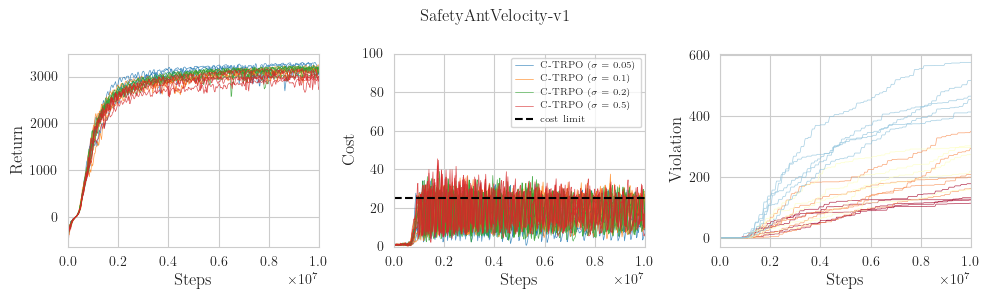

In [25]:
LABEL_MAP = {
    #"c-trpo (benchmark)": "C-TRPO",
    "c-trpo-noise (noise_0_1)": r"C-TRPO ($\sigma=0.1$)",
    "c-trpo-noise (noise_0_2)": r"C-TRPO ($\sigma=0.2$)",
    "c-trpo-noise (noise_0_5)": r"C-TRPO ($\sigma=0.5$)",
    "c-trpo-noise (noise_0_05)": r"C-TRPO ($\sigma=0.05$)",
}
df = get_df(algo_subset = ("c-trpo","c-trpo-noise"),
            env_subset = ENVS,
            experiments = ("benchmark", "noise_0_1", "noise_0_2", "noise_0_05", "noise_0_5"))

for env in df["env"].drop_duplicates():
    plot_env(df, env, label_map=LABEL_MAP)

In [28]:
import numpy as np
import scipy

from rliable import library as rly
from rliable import metrics as rl_metrics
from rliable import plot_utils

metrics = [
    "Metrics/EpRet",  # normalize: PPO
    "Metrics/EpCost",  # normalize: cost threshold/limit
    "Metrics/EpCumCostViolation"  # normalize: CPO as baseline
]

metric_names = [
    "Reward", 
    "Final Cost", 
    "Cumulative Cost"
]

algos_to_plot = ["c-trpo-noise (noise_0_05)", "c-trpo-noise (noise_0_5)", "c-trpo-noise (noise_0_1)", "c-trpo-noise (noise_0_2)"]

normalized_score_dict_samples = {}

steps = np.array(range(1, 11))*1_000_000

for i, env in enumerate(ENVS):
    normalized_score_dict_samples[env] = {}
    for metric in metrics:
        normalized_score_dict_samples[env][metric] = {}
        for algo in algos_to_plot:
            normalized_score_dict_samples[env][metric][algo] = np.zeros((5, 10))
            for j, step in enumerate(steps):
                # display(df_filtered)
                df_filtered = df[df["env"] == env]
                data = np.array(df_filtered[(df_filtered["algo"]==algo) & (df_filtered["Train/TotalSteps"] == step)][metric])
                if not data.size == 0:
                    normalized_score_dict_samples[env][metric][algo][:,j] = data
                else:
                    print(f"Warning: empty data for {algo}, {env}")

iqm_scores, iqm_cis = {}, {}

for env in ENVS:
    print(f"Compute IQM scores and confidence intervals for {env}:", end="")
    iqm_scores[env] = {}
    iqm_cis[env] = {}
    for metric, metric_name in zip(metrics, metric_names):
        print(f" ...{metric_name}", end="")
        iqm = lambda scores: np.array([rl_metrics.aggregate_iqm(scores[..., frame])
                                        for frame in range(scores.shape[-1])])

        iqm_scores[env][metric_name], iqm_cis[env][metric_name] = rly.get_interval_estimates(
        normalized_score_dict_samples[env][metric], iqm, reps=50000)
        print(f", ", end="")
    print("")

Compute IQM scores and confidence intervals for SafetyAntVelocity-v1: ...Reward,  ...Final Cost,  ...Cumulative Cost, 


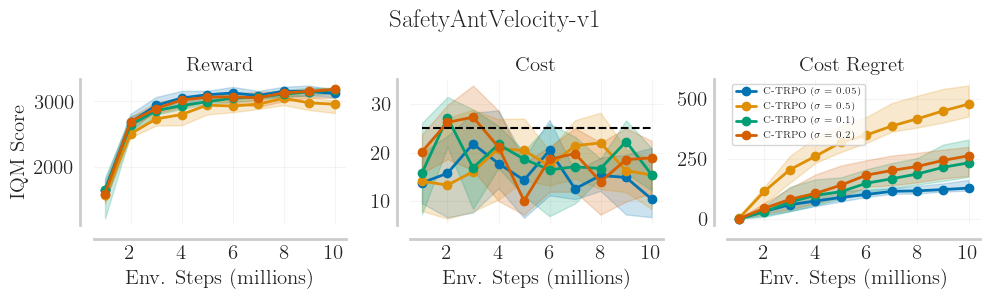

In [35]:
for env in ENVS:
    fig, axs = plt.subplots(1, 3, figsize=(10, 3))

    for i, (metric_name, ax) in enumerate(zip(metric_names, axs)):
        plot_utils.plot_sample_efficiency_curve(
            np.array(range(1,11)), {LABEL_MAP[algo]: data for algo, data in iqm_scores[env][metric_name].items()}, {LABEL_MAP[algo]: data for algo, data in iqm_cis[env][metric_name].items()}, ax=ax,
            xlabel=r'Env. Steps (millions)',
            ylabel="IQM Score" if i == 0 else "",
            labelsize=15,
            ticklabelsize=15,
            # legend=True if (i == 0) else False,
        )

        if metric_name == "Cumulative Cost":
            ax.set_title("Cost Regret", fontsize=15)
        elif metric_name == "Final Cost":
            ax.set_title("Cost", fontsize=15)
        else:
            ax.set_title("Reward", fontsize=15)
        ax.set_xticks([2, 4, 6, 8, 10])
    fig.suptitle(env, fontsize=18)
    
    axs[1].plot([1, 10], [25.0, 25.0], color="black", linestyle="dashed", label="limit", zorder=10)

    plt.legend(prop={'size': 7})

    plt.tight_layout()

    plt.savefig(os.path.join("..", "graphics", f"noise.pdf"), dpi=600)